In [5]:
#123
!pip install geojson
!pip install turfpy

  Preparing metadata (setup.py) ... done
  Created wheel for turfpy: filename=turfpy-0.0.7-py3-none-any.whl size=39098 sha256=d8d9c5c88c86a4cbfb991f30165a179e7caa3f0ee6d857e890d6122e0b8bb5f6
  Stored in directory: /root/.cache/pip/wheels/7a/05/e3/11a72686a770c2117b4465d02abd5f25f8d94c2f823ca0c112
Successfully built turfpy


In [6]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.graph_objects as go
import json
from turfpy.measurement import boolean_point_in_polygon, centroid, distance

from geojson import Point, MultiPolygon, Feature, load, LineString
#from geojson.utils import coords
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd



#CSV path
file_path = '/content/Transit Data - October.xlsx'
neighbourhoods_path = '/content/drive/MyDrive/Datasets/neighbourhoods.csv'
driveway_path = '/content/drive/MyDrive/Datasets/driveways.csv'
POI_path = '/content/drive/MyDrive/Datasets/point-of-interest.csv'
population_path ="/content/drive/MyDrive/Datasets/neighbourhood-census-profiles-family-housing-mobility.csv"

#Geo Json path
neighbourhoods_geo_path = '/content/drive/MyDrive/Datasets/geo/neighbourhoods.geojson'





In [27]:
#constant value
bus_cap = 51 #https://www.ttc.ca/riding-the-ttc/Real-Time-Bus-Occupancy-Info
cars_per_driveway = 2
gas_emission_car = 206 #https://www.nationalobserver.com/2019/09/04/analysis/canadian-cars-are-worlds-dirtiest-ev-age-essential
gas_emission_bus = 1300 #https://www.carbonindependent.org/20.html
bus_it_queens = 122 #From solus
total_enroll = 28142  #https://www.queensu.ca/registrar/sites/uregwww/files/uploaded_files/pdfs/Reports/Enrolment%20Plans/Reduced%20Size/Enrolment%20Projections%20for%202020-23%20.pdf
multi_ride_pass = 13.50 #6 times, https://www.cityofkingston.ca/residents/transit/fares#multi-ride


In [48]:
#Load data
df = pd.read_csv(driveway_path, ';')

#Data Cleaning
df.describe()

<ipython-input-48-9a35c9e5c510>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv(driveway_path, ';')


,"﻿""STATUS""",MATERIAL,GeoJSON,geo_point_2d
count,45305,45306,45304,45304
unique,2,7,45304,45304
top,ACTIVE,PAVEMENT,"{""type"": ""Polygon"", ""coordinates"": [[[-76.3850...","44.3003829116,-76.3851235304"
freq,45299,44538,1,1


In [49]:
#Remove missing entries
df.isnull().sum()
df_cleaned= df.dropna()
df_cleaned.describe()


,"﻿""STATUS""",MATERIAL,GeoJSON,geo_point_2d
count,45302,45302,45302,45302
unique,2,7,45302,45302
top,ACTIVE,PAVEMENT,"{""type"": ""Polygon"", ""coordinates"": [[[-76.3850...","44.3003829116,-76.3851235304"
freq,45296,44537,1,1


#Check Status

In [50]:
column_names = df_cleaned.columns
col_1 = column_names[0]
df_cleaned[col_1].value_counts()



ACTIVE      45296
PROPOSED        6
Name: ﻿"STATUS", dtype: int64

Remove the "PROPOSED" driveways

In [51]:
df_filtered = df_cleaned[df_cleaned[column_names[0]] != 'PROPOSED']
df_filtered.describe()

#Extract coor
driveway_coords = df_filtered['geo_point_2d'].str.split(',', expand=True).astype(float).rename(columns={0:'Latitude', 1:'Longitude'})
print("Total number of  driveways: " + str(len(driveway_coords)))

Total number of  driveways: 45296


#Calculate the center of each community and their distance to DT

In [52]:
# coor of DT
df = pd.read_csv(POI_path, ';')
dt = df.loc[df['NAME'] == 'DOWNTOWN TRANSFER POINT', 'geo_point_2d'].values[0]
dt_lon = float(dt.split(',')[0])
dt_lat = float(dt.split(',')[1])
dt_coords = (dt_lat, dt_lon)
# Create geojson feature
#Longitude & Latitude are reversed in order to match the order in neighbourhoods dataset
dt = Feature(geometry=Point(dt_coords))
print(dt)

<ipython-input-52-458b61d684b8>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv(POI_path, ';')


{"geometry": {"coordinates": [-76.484538, 44.231033], "type": "Point"}, "properties": {}, "type": "Feature"}


In [53]:
#Calculate centre of each communities and distance to DT

#df = pd.read_csv(neighbourhoods_path, ';')
neighbourhoods = load(open(neighbourhoods_geo_path))

for feature in neighbourhoods['features']:
    prop = feature['properties']
    # key in dic
    prop['driveway_count'] = 0
    prop['distance_by_cars'] = 0
    # calc the center
    prop['center'] = [prop['geo_point_2d'][1], prop['geo_point_2d'][0]]
    # calc the dist
    prop['distance_to_dt'] = distance(prop['center'], dt)
    print(f"{prop['name']}\ncenter: {prop['center']}\ndistance to dt: {prop['distance_to_dt']}")



Marker's Acres
center: [-76.4771728869, 44.2714786831]
distance to dt: 4.535457064114973
Polson Park
center: [-76.531278662, 44.2349356915]
distance to dt: 3.7491355874720522
Reddendale
center: [-76.5619866269, 44.2147418199]
distance to dt: 6.431934269683744
Rideau Heights
center: [-76.4786067235, 44.2586377482]
distance to dt: 3.1056604074598266
Williamsville
center: [-76.4997995741, 44.2387322586]
distance to dt: 1.4870501314874447
Alwington
center: [-76.506054655, 44.222867176]
distance to dt: 1.9400581648860187
Fairway Hills
center: [-76.5362314921, 44.2265055819]
distance to dt: 4.1494856036355126
Westwoods
center: [-76.5989073706, 44.2565609504]
distance to dt: 9.542370676051416
Ravensview
center: [-76.4014688375, 44.2505768489]
distance to dt: 6.965134446482638
Ravensview
center: [-76.3982275315, 44.244863644]
distance to dt: 7.0458591427837725
Mile Square
center: [-76.6261884403, 44.241209487]
distance to dt: 11.341603128661301
Joyceville / Brewer's Mills
center: [-76.28596206

In [54]:
#Longitude & Latitude are reversed in order to match the order in neighbourhoods dataset
for driveway in zip(driveway_coords['Longitude'], driveway_coords['Latitude']):
    # convert tuple to a geojson feature
    driveway = Feature(geometry=Point(driveway))
    # determine which neighbourhood the driveway belongs to
    for features in neighbourhoods['features']:
        if boolean_point_in_polygon(driveway, features):
            # Increment driveway count for the neighbourhood
            features['properties']['driveway_count'] += 1
            # Add up all the car milage for each driveway in the neighbourhood
            # (2 cars per driveway)
            features['properties']['distance_by_cars'] += 2 * distance(driveway, dt)
            break


In [55]:
for neighbourhood in neighbourhoods['features']:
    prop = neighbourhood['properties']
    print(f"{prop['name']} driveway count: {prop['driveway_count']}\ndistance to dt: {prop['distance_by_cars']}")

Marker's Acres driveway count: 1080
distance to dt: 9266.305403947135
Polson Park driveway count: 398
distance to dt: 2891.6648998106134
Reddendale driveway count: 592
distance to dt: 8343.371726977526
Rideau Heights driveway count: 1363
distance to dt: 8712.914112038177
Williamsville driveway count: 453
distance to dt: 1288.9364293787655
Alwington driveway count: 425
distance to dt: 1662.4136656093854
Fairway Hills driveway count: 489
distance to dt: 3822.7509578732015
Westwoods driveway count: 2220
distance to dt: 42169.15463664841
Ravensview driveway count: 371
distance to dt: 5283.005472545798
Ravensview driveway count: 0
distance to dt: 0
Mile Square driveway count: 967
distance to dt: 20701.212401155513
Joyceville / Brewer's Mills driveway count: 880
distance to dt: 39733.37292453955
Grenville Park driveway count: 310
distance to dt: 2512.462783022604
Waterloo Village driveway count: 734
distance to dt: 8619.26513864703
St. Lawrence North driveway count: 0
distance to dt: 0
Auden

In [56]:
#Calculate the number of buses needed and distance travlled by these buses
total_route_needed = 0
for features in neighbourhoods['features']:
  prop = features['properties']
  prop['bus_num'] = math.ceil(prop['driveway_count'] * cars_per_driveway / bus_cap)
  #Distance travlled by bus
  prop['distance_by_bus'] = prop['bus_num'] * prop['distance_to_dt']
  total_route_needed += prop['bus_num']


In [57]:
print(f'Total new routes needed for this solution: {total_route_needed}')

Total new routes needed for this solution: 1786


In [63]:
#Assuming each route only run twice a day, compare to the driver leave and return home.
#Calculate the gas emissions
total_emission_by_car = 0
total_emission_by_bus = 0
for features in neighbourhoods['features']:
  prop = features['properties']
  total_emission_by_car += prop['distance_by_cars'] * gas_emission_car * 2
  total_emission_by_bus += prop['distance_by_bus'] * gas_emission_bus * 2


In [64]:
print(f"Gas emission by car: {total_emission_by_car}\nGas emission by bus: {total_emission_by_bus}\nRatio: {total_emission_by_car/total_emission_by_bus}")

Gas emission by car: 250706229.69353655
Gas emission by bus: 33631565.90551927
Ratio: 7.454491723574287


Switching to buses can reduce gas emissions by about 7.5 times.

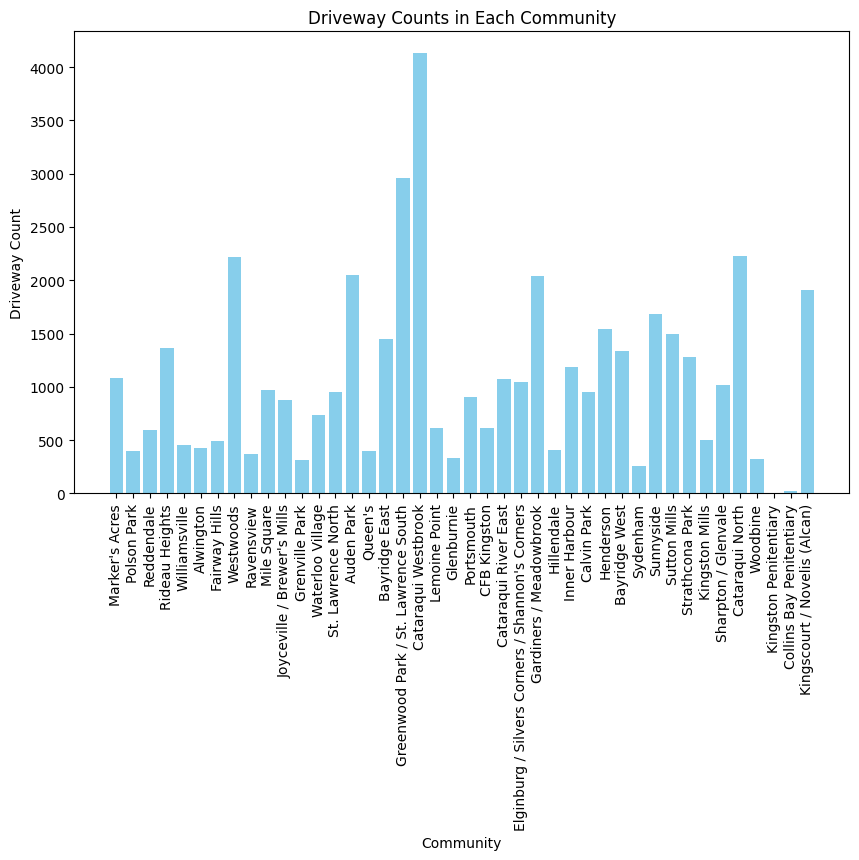

In [60]:
# Chart 1 (maybe 2?): # of driveways in each community + the driveways vs. population:
#Finding: Some commnuities have sucifficent driveways compared to the population while some has shortages.
#It shows the limitation of this solution, since the assumbtion is each driveway two cars.
community_names = []
driveway_counts = []
bus_needed_counts = []
for features in neighbourhoods['features']:
  prop = features['properties']
  community_names.append(prop['name'])
  driveway_counts.append(prop['driveway_count'])
  bus_needed_counts.append(prop['bus_num'])

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(community_names, driveway_counts, color='skyblue')

plt.xticks(rotation='vertical')

plt.xlabel('Community')
plt.ylabel('Driveway Count')
plt.title('Driveway Counts in Each Community')
plt.show()

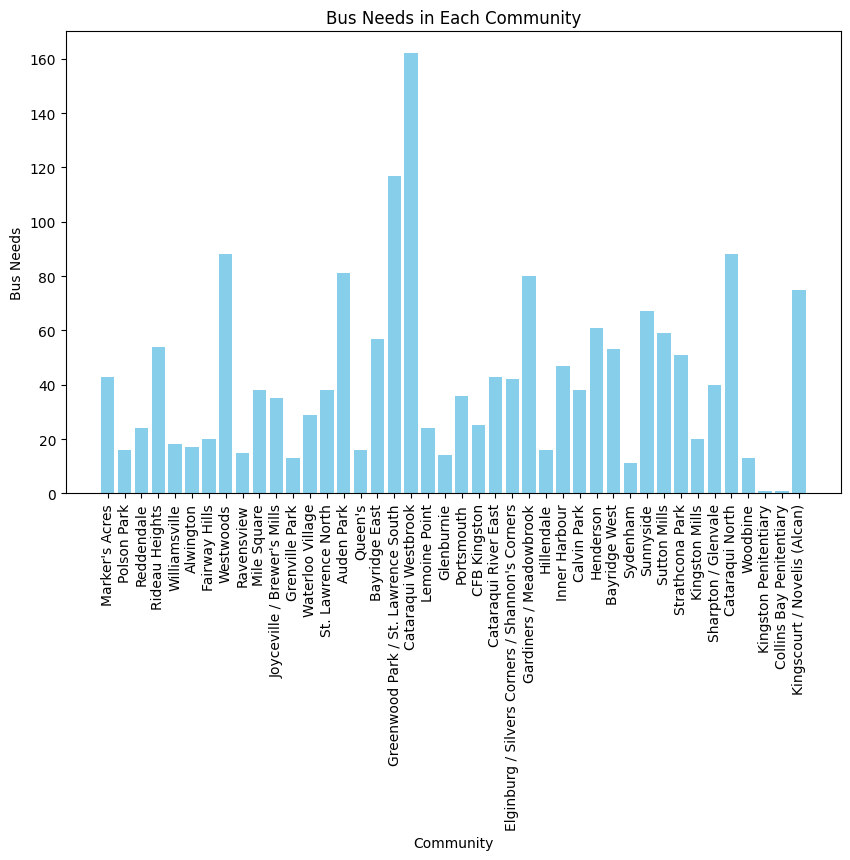

In [62]:
# Bar chart for bus needs in each community
plt.figure(figsize=(10, 6))
plt.bar(community_names, bus_needed_counts, color='skyblue')

plt.xticks(rotation='vertical')

plt.xlabel('Community')
plt.ylabel('Bus Needs')
plt.title('Bus Needs in Each Community')
plt.show()


In [67]:
df = pd.read_csv(population_path)


In [68]:
selected_columns = df[['Area ID Number', 'Total Population 2016']]
selected_columns['driveway_count'] = 0

for feature in neighbourhoods['features']:
    area_id = feature['properties']['neighbourhood_id']
    # 如果 'Area ID Number' 在 DataFrame 中，则更新对应的值
    if area_id in df['Area ID Number'].values:
        selected_columns.loc[selected_columns['Area ID Number'] == area_id, 'driveway_count'] = feature['properties']['driveway_count']

<ipython-input-68-5667bbc1a12f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['driveway_count'] = 0


<ipython-input-70-69122389aa03>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['driveway_count', 'Total Population 2016']] = scaler.fit_transform(df[['driveway_count', 'Total Population 2016']])


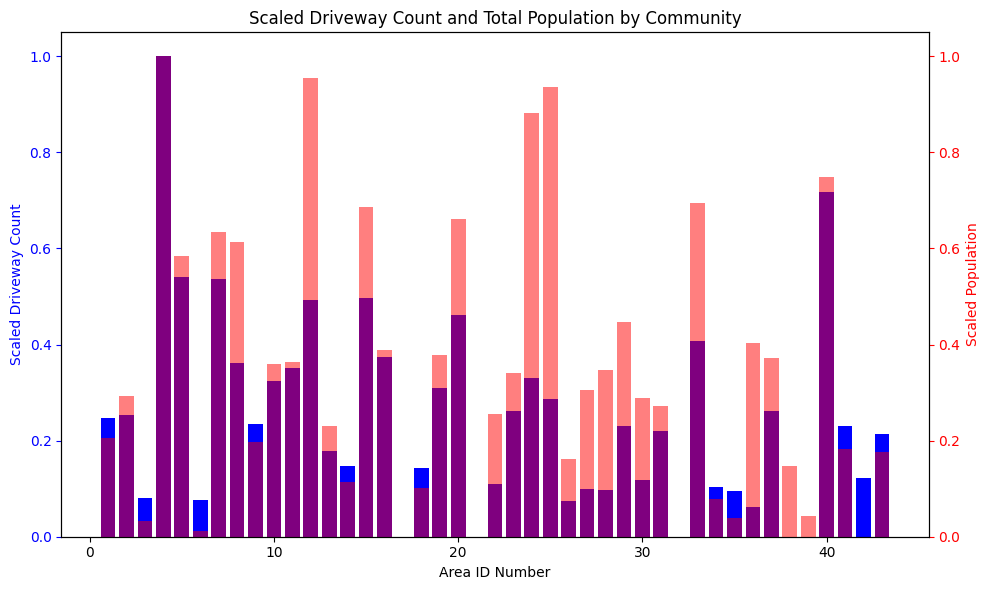

In [70]:
df = selected_columns[selected_columns['Area ID Number'] != 0]

# Scaling the data
scaler = MinMaxScaler()
df[['driveway_count', 'Total Population 2016']] = scaler.fit_transform(df[['driveway_count', 'Total Population 2016']])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for scaled driveway count
ax1.bar(df['Area ID Number'], df['driveway_count'], color='blue', label='Driveway Count')
ax1.set_xlabel('Area ID Number')
ax1.set_ylabel('Scaled Driveway Count', color='blue')
ax1.tick_params('y', colors='blue')

# Bar chart for scaled population
ax2 = ax1.twinx()
ax2.bar(df['Area ID Number'], df['Total Population 2016'], color='red', alpha=0.5, label='Total Population 2016')
ax2.set_ylabel('Scaled Population', color='red')
ax2.tick_params('y', colors='red')

# Adding title and legend
plt.title('Scaled Driveway Count and Total Population by Community')
fig.tight_layout()
plt.show()

#Chart 3 comparetion of emission by car and bus


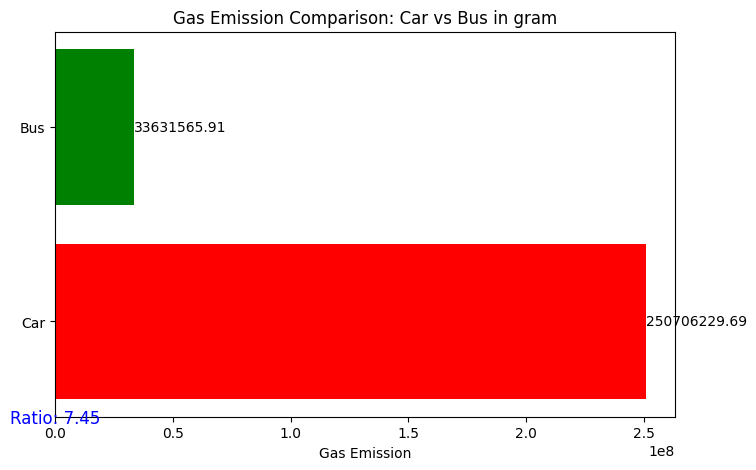

In [65]:
car_emission = total_emission_by_car
bus_emission = total_emission_by_bus

# Calculate the ratio
emission_ratio = car_emission / bus_emission

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal bar chart
bars = ax.barh(['Car', 'Bus'], [car_emission, bus_emission], color=['red', 'green'])
ax.set_xlabel('Gas Emission')
ax.set_title('Gas Emission Comparison: Car vs Bus in gram')

# Adding text annotations without scientific notation
for bar in bars:
    yval = bar.get_width()
    plt.text(yval, bar.get_y() + bar.get_height()/2, f'{yval:.2f}', va='center', ha='left', color='black')

# Adding ratio information
plt.text(0.5, -0.5, f'Ratio: {emission_ratio:.2f}', ha='center', va='center', fontsize=12, color='blue')

plt.show()


<ipython-input-324-ccc4c008f54a>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set3', len(gdf_neighbourhoods))


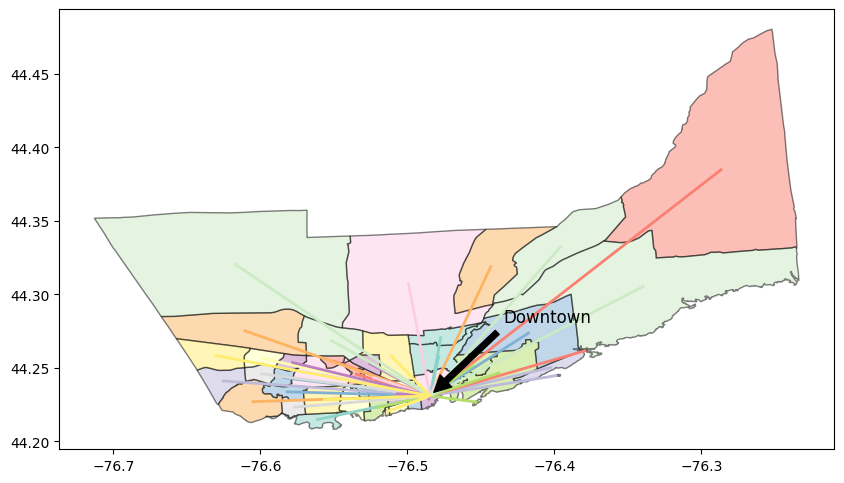

In [ ]:

# Assuming neighborhoods is a GeoDataFrame with a "geometry" column containing polygons and a "name" column
# Also assuming dt_coords is a tuple containing Downtown's coordinates (lon, lat)

# Create GeoDataFrame
gdf_neighbourhoods = gpd.GeoDataFrame(neighbourhoods['features'], geometry='geometry')

# Create Downtown point
dt_point = Point(dt_coords)

# Create a color map for neighborhoods
colormap = plt.cm.get_cmap('Set3', len(gdf_neighbourhoods))

# Plot GeoDataFrame with neighborhood colors
ax = gdf_neighbourhoods.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', cmap=colormap)

# Connect each neighborhood's center to Downtown with lines and color them based on the colormap
for idx, row in gdf_neighbourhoods.iterrows():
    centroid = row['geometry'].centroid
    line = LineString([centroid, dt_point])
    gpd.GeoSeries(line).plot(ax=ax, color=colormap(idx), linewidth=2)

# Set Downtown label
ax.annotate('Downtown', xy=(dt_coords[0], dt_coords[1]), xytext=(dt_coords[0] + 0.05, dt_coords[1] + 0.05),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Display the plot
plt.show()


How the new routes will look like

In [9]:
#Q4 Something Interesting

df = pd.read_excel('/content/drive/MyDrive/Datasets/Transit Data - October.xlsx')



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704539 entries, 0 to 704538
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       704539 non-null  datetime64[ns]
 1   Time       704539 non-null  datetime64[ns]
 2   Class      704539 non-null  object        
 3   Operation  704539 non-null  object        
 4   Bus        704539 non-null  int64         
 5   Route      704539 non-null  int64         
 6   Latitude   704539 non-null  float64       
 7   Longitude  704539 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 43.0+ MB


,Date,Time,Class,Operation,Bus,Route,Latitude,Longitude
0,2017-10-01,1900-01-01 01:43:03,QUEENS,Exact Fare,620,17,44.227860,-76.496938
1,2017-10-01,1900-01-01 01:43:08,QUEENS,Exact Fare,620,17,44.227860,-76.496938
2,2017-10-01,1900-01-01 01:58:13,ADULT,Pass (Multi-ride card),620,17,44.232035,-76.491397
3,2017-10-01,1900-01-01 01:58:25,QUEENS,Exact Fare,620,17,44.232035,-76.491397
4,2017-10-01,1900-01-01 01:58:27,QUEENS,Exact Fare,620,17,44.232035,-76.491397


In [45]:
df['Operation'].value_counts()

Exact Fare                            380789
Pass (Multi-ride card)                216614
Transfer - Pass (Multi-ride card)      58113
Rides (Multi-ride card)                35321
Transfer - Printed Ticket               7204
Transfer - Rides (Multi-ride card)      6498
Name: Operation, dtype: int64

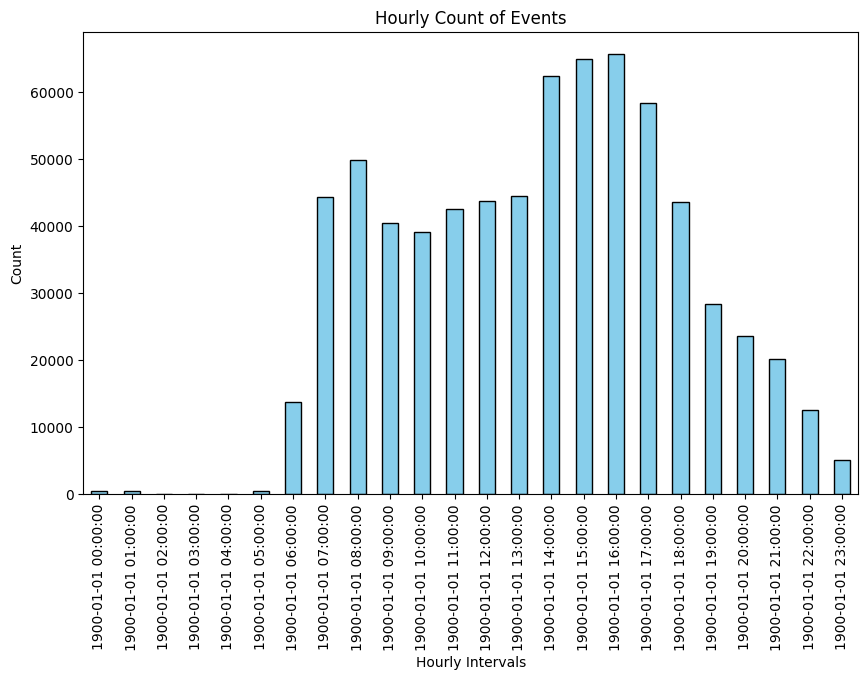

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

# Set 'Time' as the index
df.set_index('Time', inplace=True)

# Resample data in one-hour intervals and count occurrences
hourly_counts = df.resample('1H').size()

# Plotting
hourly_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.xlabel('Hourly Intervals')
plt.ylabel('Count')
plt.title('Hourly Count of Events')
plt.show()


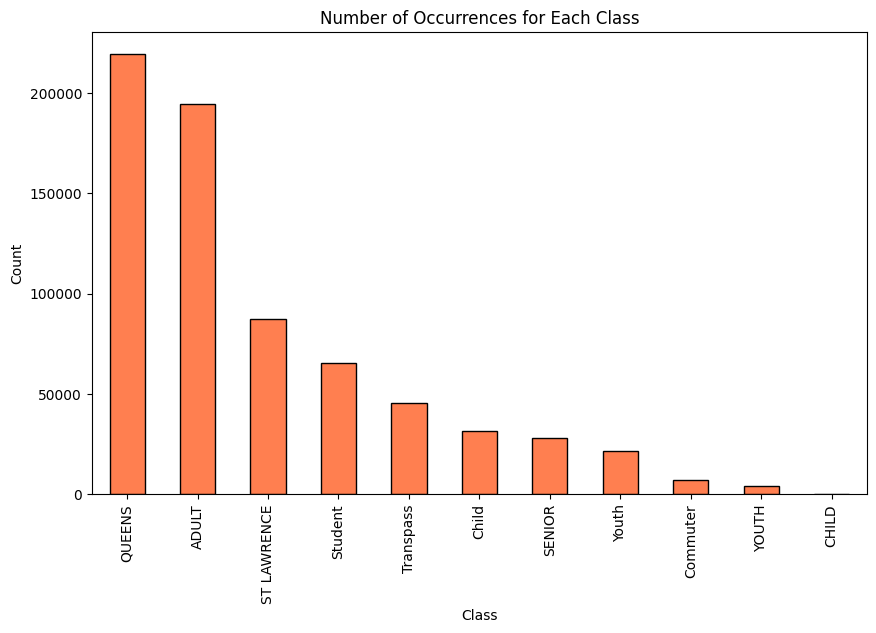

In [11]:
class_counts = df['Class'].value_counts()

# Plotting
class_counts.plot(kind='bar', figsize=(10, 6), color='coral', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Occurrences for Each Class')
plt.show()

The total amount Queens' students paid in one year: 3433324
The theoretical cost by multi-pass in Oct.: 493411.5
The average amount Queens' paid in a month: 286110.3333333333


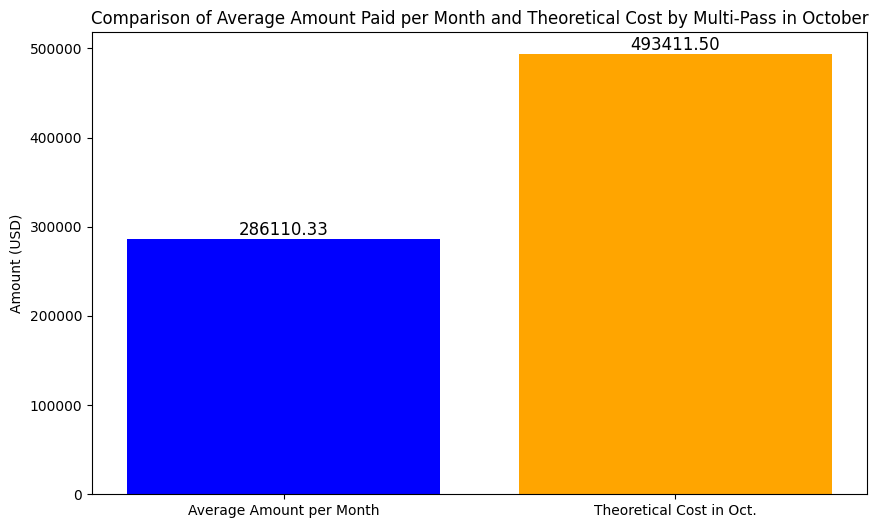

In [71]:
Total_student_paid = total_enroll * bus_it_queens
Theoretical_cost_by_multi_pass = class_counts[0] * multi_ride_pass / 6
average_amount_per_month = Total_student_paid / 12

print(f"The total amount Queens' students paid in one year: {Total_student_paid}")
print(f"The theoretical cost by multi-pass in Oct.: {Theoretical_cost_by_multi_pass}")
print(f"The average amount Queens' paid in a month: {average_amount_per_month}")

# Plotting
plt.figure(figsize=(10, 6))

# Bar chart for the average amount paid per month and theoretical cost by multi-pass in Oct.
bars = plt.bar(['Average Amount per Month', 'Theoretical Cost in Oct.'], [average_amount_per_month, Theoretical_cost_by_multi_pass], color=['blue', 'orange'])

# Adding values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black', fontsize=12)

plt.ylabel('Amount (USD)')
plt.title("Comparison of Average Amount Paid per Month and Theoretical Cost by Multi-Pass in October")
plt.show()

In theoretically, the bus plan offered to students saves their money when they have bus needs.
However, there may exist bias:
students may not choose bus if they don't have the plan;
student may turn to use bus more offten even they can walk.

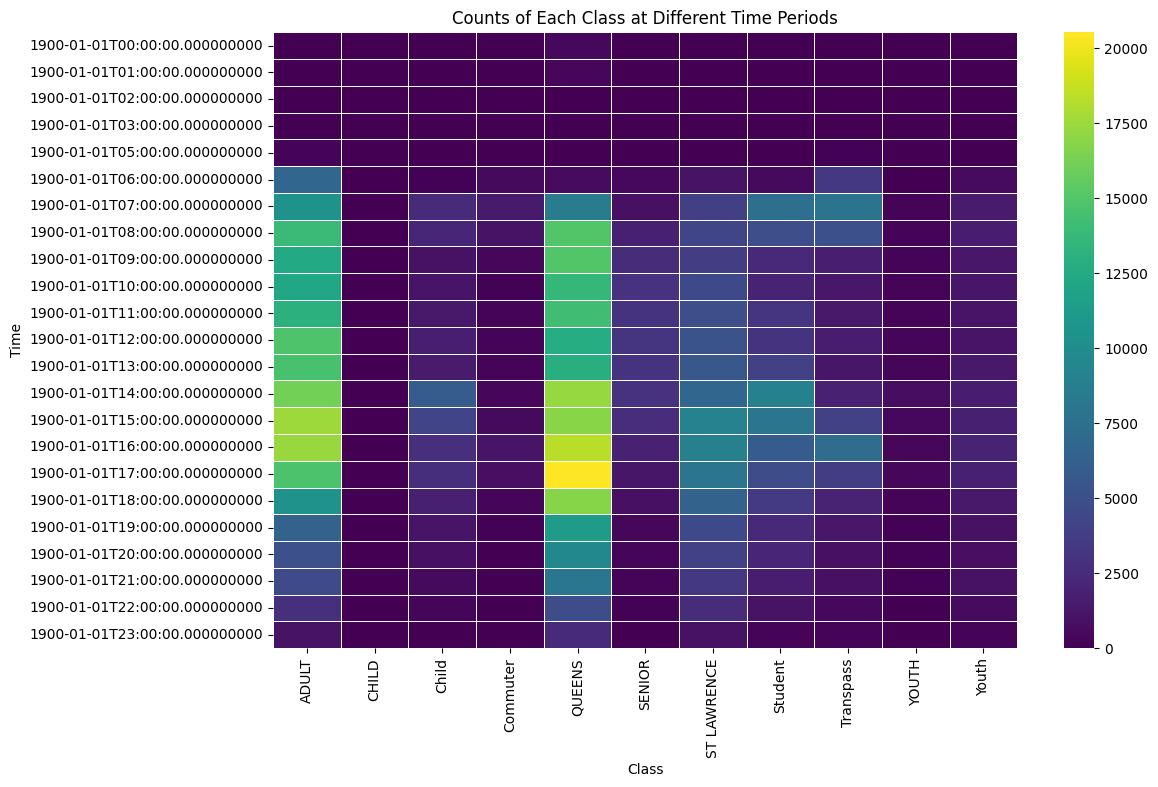

In [ ]:
#chart No.？, shows in each time period, the count of each class
df.index = df.index.floor('H')

# Group by both time and class, count occurrences, and reset index
grouped_data = df.groupby(['Time', 'Class']).size().reset_index(name='Count')

# Pivot the table to get Class as columns
pivot_table = grouped_data.pivot(index='Time', columns='Class', values='Count').fillna(0)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', linewidths=.5)
plt.xlabel('Class')
plt.ylabel('Time')
plt.title('Counts of Each Class at Different Time Periods')
plt.show()

In [ ]:
total_route_count = df['Route'].value_counts()

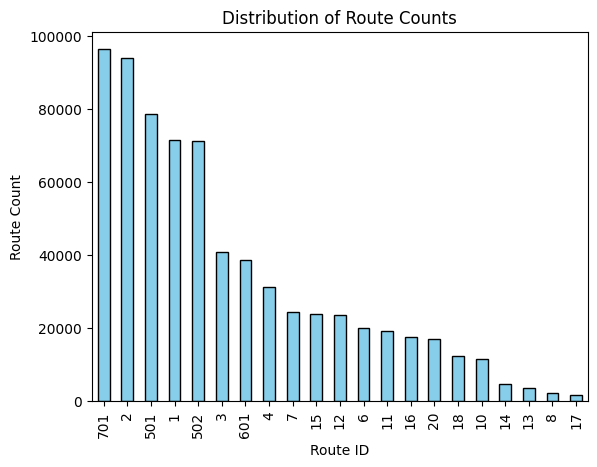

In [ ]:
# Plotting the bar chart
total_route_count.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Route ID')
plt.ylabel('Route Count')
plt.title('Distribution of Route Counts')

# Display the plot
plt.show()


In [ ]:
# Define the valid ranges for Latitude and Longitude
valid_latitude_range = (40, 50)
valid_longitude_range = (-80, -70)

# Filter entries with Latitude outside the valid range
invalid_latitude = (df['Latitude'] < valid_latitude_range[0]) | (df['Latitude'] > valid_latitude_range[1])

# Filter entries with Longitude outside the valid range
invalid_longitude = (df['Longitude'] < valid_longitude_range[0]) | (df['Longitude'] > valid_longitude_range[1])

# Combine the conditions to get the final set of invalid entries
invalid_entries = df[invalid_latitude | invalid_longitude]

# Display the invalid entries
print(invalid_entries)

             Date                Time   Class                Operation   Bus  \
49     2017-10-01 1900-01-01 08:10:05   Youth   Pass (Multi-ride card)   623   
51     2017-10-01 1900-01-01 08:12:24   Child               Exact Fare  1367   
52     2017-10-01 1900-01-01 08:12:25   ADULT   Pass (Multi-ride card)  1367   
54     2017-10-01 1900-01-01 08:26:01   ADULT   Pass (Multi-ride card)   729   
55     2017-10-01 1900-01-01 08:26:21  SENIOR   Pass (Multi-ride card)   729   
...           ...                 ...     ...                      ...   ...   
704468 2017-10-01 1900-01-01 16:54:22   ADULT   Pass (Multi-ride card)   729   
704470 2017-10-01 1900-01-01 16:54:43   Child               Exact Fare   624   
704476 2017-10-01 1900-01-01 16:56:19  QUEENS               Exact Fare   729   
704477 2017-10-01 1900-01-01 16:56:21  QUEENS               Exact Fare   729   
704488 2017-10-01 1900-01-01 16:46:01   ADULT  Rides (Multi-ride card)  1367   

        Route  Latitude  Longitude  
49

In [ ]:
invalid_route_counts = invalid_entries['Route'].value_counts()

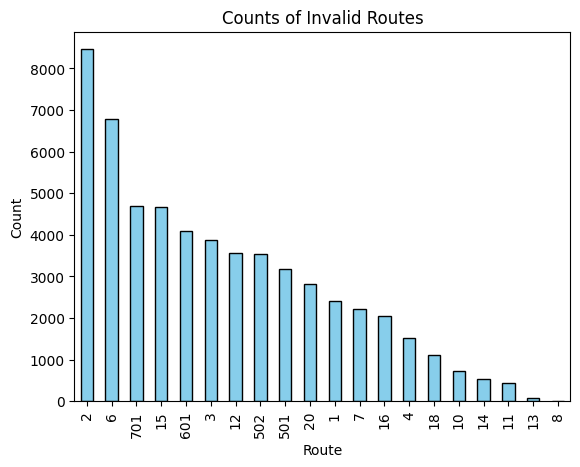

In [ ]:
invalid_route_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Counts of Invalid Routes')

# Show the plot
plt.show()

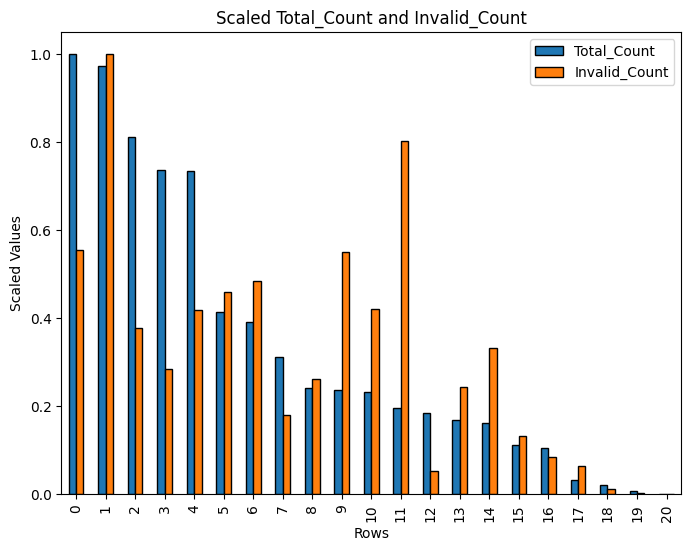

In [ ]:
total_route_count = pd.Series(total_route_count, name='Total_Count')
invalid_route_counts = pd.Series(invalid_route_counts, name='Invalid_Count')

# Combine the two Series into a DataFrame
combined_df = pd.concat([total_route_count, invalid_route_counts], axis=1)
combined_df = combined_df.fillna(0)

from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Scale the two columns
combined_df_scaled = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot for scaled values
combined_df_scaled.plot(kind='bar', ax=ax, edgecolor='black')
plt.title('Scaled Total_Count and Invalid_Count')
plt.xlabel('Rows')
plt.ylabel('Scaled Values')
plt.show()



Route 9,10,11,14 has higher pecentage of invalid records compared to the others.

In [ ]:
transit_routes = load(open('/content/drive/MyDrive/Datasets/geo/transit-gtfs-routes.geojson'))

    Route  TotalCount  InvalidCount  Invalid Percentage
0     701       96384        4701.0            0.048774
1       2       93880        8461.0            0.090126
2     501       78520        3184.0            0.040550
3       1       71450        2411.0            0.033744
4     502       71229        3547.0            0.049797
5       3       40953        3886.0            0.094889
6     601       38617        4097.0            0.106093
7       4       31207        1511.0            0.048419
8       7       24508        2211.0            0.090215
9      15       24001        4659.0            0.194117
10     12       23567        3566.0            0.151313
11      6       20116        6794.0            0.337741
12     11       19183         448.0            0.023354
13     16       17555        2058.0            0.117232
14     20       16939        2815.0            0.166185
15     18       12349        1113.0            0.090129
16     10       11683         720.0            0

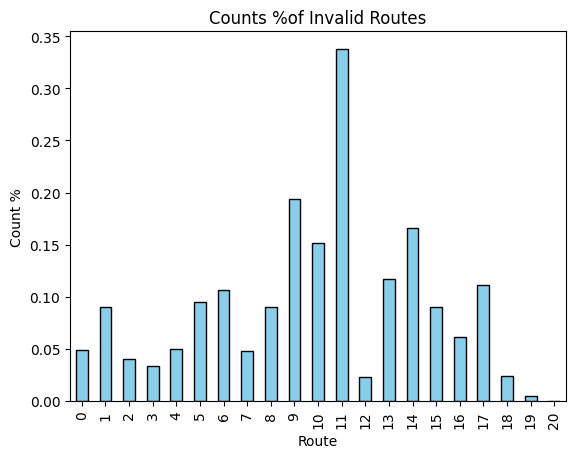

In [ ]:
#Chart 4
# Create DataFrames from Series
invalid_df = pd.DataFrame({'Route': invalid_route_counts.index, 'InvalidCount': invalid_route_counts.values})
total_df = pd.DataFrame({'Route': total_route_count.index, 'TotalCount': total_route_count.values})

# Merge DataFrames on 'Route'
combined_df = pd.merge(total_df, invalid_df, on='Route', how='left').fillna(0)
combined_df['Invalid Percentage'] = combined_df['InvalidCount']/combined_df['TotalCount']
# Display the combined DataFrame
print(combined_df)

combined_df['Invalid Percentage'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Route')
plt.ylabel('Count %')
plt.title('Counts %of Invalid Routes')

# Show the plot
plt.show()

Line 11 has the most invalid records. The reason may be that the No. 11 bus is too old, the equipment is worn out, or there is interference to the GPS signal somewhere during transit.